# Background

## Double Gyre Experiment

This example will use a rotating double gyre flow (B.A. Mosovsky and J.D. Meiss. Transport in transitory dynamical systems. *SIAM Journal on Applied Dynamical Systems*, 10(1):35-65, 2011.), a Hamiltonian system with Hamiltonian  $H = - \psi$, where $\psi$ is the stream function

$$
\psi(x,y,t) = (1-s(t))\psi_P (x,y) + s(t)\psi_F (x,y) \\
\psi_P(x,y) = sin(2\pi x)sin(\pi y) \\
\psi_F(x,y) = sin(\pi x)sin(2\pi y)
$$

and transition function
$$
s(t) = 0, \qquad t < 0 \\
s(t) = t^2 (3-2t), \qquad t \in [0,1] \\
s(t) = 1, \qquad t > 1
$$

## Step 1: Import required python packages

In [1]:
""" Double Gyre Matlab to Python conversion
- MATLAB code from FEMDL Matlab
"""
# Add path to FEMDL code 
#import sys
#sys.path.append('../../src')

# Import Statements
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.spatial import Delaunay
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigs
from matplotlib.tri import Triangulation

## Step 2: Define the rotating double gyre vector field

In [2]:
#From experiments/double_gyre/double_gyre.py
from numpy import square, pi, cos, sin, zeros_like
def rotating_double_gyre_vf(t,z):
    n = int(len(z)/2)
    x = z[0:n]
    y = z[n:]

    st = (t > 0 and t < 1)*square(t)*(3-2*t) + (t > 1)*1

    dxPsi_P = 2*pi*cos(2*pi*x)*sin(pi*y)
    dyPsi_P = pi*sin(2*pi*x)*cos(pi*y)
    dxPsi_F = pi*cos(pi*x)*sin(2*pi*y)
    dyPsi_F = 2*pi*sin(pi*x)*cos(2*pi*y)
    dxPsi = (1-st)*dxPsi_P + st*dxPsi_F
    dyPsi = (1-st)*dyPsi_P + st*dyPsi_F
    dz = zeros_like(z)
    dz[0:n]= -dyPsi
    dz[n:] = dxPsi

    return dz


## Step 3: Define some functions that we will require to solve the ODE

In [3]:
#From src/normed.py
from numpy.linalg import norm
from numpy import inf
def normed(x):
    y = x/norm(x,inf)
    return y


In [4]:
#From src/flow_map.py
import sys
from numpy import conj, transpose

def flow_map(v, x, tspan):

    x0 = x[0,:]
    y0 = x[1,:]

    [Fx,Fy] = integrator(v,x0,y0,tspan)

    y =  np.array((conj(transpose(Fx)), conj(transpose(Fy))))

    return y

In [5]:
#From src/integrator.py
from scipy import integrate
from numpy import concatenate

def integrator(v, x0, y0, tspan):
    #Ps = integrate.odeint(rotating_double_gyre_vf, np.concatenate((x0,y0)), tspan, tfirst=True)
    tminmax = np.array((tspan[0],tspan[-1]))
    Ps = integrate.solve_ivp(v, tminmax, concatenate((x0,y0)), method='RK45', vectorized=True, atol=1e-3, rtol=1e-3, t_eval=tspan)
    print('Integrator: ' + Ps.message)
    F = Ps.y

    xt = F[0:len(x0),:]
    yt = F[len(x0):,:]

    return xt, yt


## Step 4: Define some functions that we will use to assemble the stiffness and mass matrices

In [6]:
#From src/gradbasis.py
from numpy import asarray, array
def gradbasis(p,t):

    v = []
    #inserting with positions rather than append to make sure order is correct
    v.insert(0, p[:,t[:,2]] - p[:,t[:,1]])
    v.insert(1, p[:,t[:,0]] - p[:,t[:,2]])
    v.insert(2, p[:,t[:,1]] - p[:,t[:,0]])
    
    v = np.asarray(v) #make as np array so indexing is normal

    area = 0.5*(-v[2,0,:]*v[1,1,:] + v[2,1,:]*v[1,0,:])

    dphi = []
    dphi.insert(0, -v[:,1,:]/(2*area))
    dphi.insert(1, v[:,0,:]/(2*area))
    dphi = np.asarray(dphi)

    area = abs(area)

    return dphi, area

In [7]:
#From src/assemble.py
from numpy import max,concatenate, ones
from scipy.sparse import csc_matrix 
def assemble(p,t,pb=None,G=None):
    n = max(pb[1,:]) + 1
    m = len(t)

    dphi, area = gradbasis(p,t)

    D = csc_matrix((n, n))
    M = csc_matrix((n, n))
    
    
    for i in range(0,3):
        for j in range(0,3):
            #Is the formula for Dij wrong?
            Dij = -area*(dphi[0,i,:]*G[:,0]*dphi[0,j,:] + dphi[0,i,:]*G[:,1]*dphi[1,j,:] + dphi[1,i,:]*G[:,1]*dphi[0,j,:] + dphi[1,i,:]*G[:,2]*dphi[1,j,:])
            Mij = area/12*np.ones(np.shape(dphi[0,i]))
            I = pb[1, t[:,i]]
            J = pb[1, t[:,j]]
            
            if (i == j):
                D = D + csc_matrix((Dij, (I,J)), shape=(n,n))           
                M = M + csc_matrix((Mij+ area/12, (I,J)), shape=(n,n))

            else:
                D = D + csc_matrix((concatenate((Dij,Dij)), (concatenate((I,J)), concatenate((J,I)))), shape=(n,n))
                M = M + csc_matrix((concatenate((Mij,Mij)), (concatenate((I,J)), concatenate((J,I)))), shape=(n,n))
    
    return [D, M]

## Step 5: Set initial conditions

In [8]:
# Flow map
t0 = 0; tf = 1; nt = 6; tspan = np.linspace(t0, tf, nt)

# Data points
n = 25; x = np.linspace(0,1,n)
[X,Y] = np.meshgrid(x,x, indexing = 'ij')
p = np.zeros((nt,2,np.square(n)))
p_0 = np.concatenate((np.concatenate((X), axis=None), np.concatenate((Y), axis=None)), axis=None)
p[0] = np.reshape(p_0, (-1,np.square(n)))
pb = np.array([np.arange(0,np.square(n)), np.arange(0,np.square(n))])

## Step 6: Solve the ODE for each time step and save the results

In [9]:
# Time Integration
P = flow_map(rotating_double_gyre_vf, p[0], tspan)

# Save the results in an array p
for k in range(1,nt):
    p_val = np.concatenate((P[0][k,:],  P[1][k,:]), axis=None)
    p[k] = np.reshape(p_val, (-1,np.square(n)))

Integrator: The solver successfully reached the end of the integration interval.


## Step 7: Plot current positions in the Eulerian frame (coloured by initial x-position)

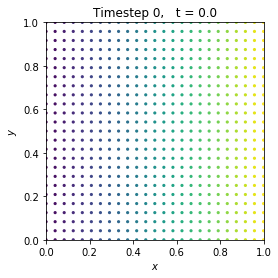

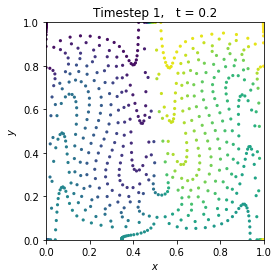

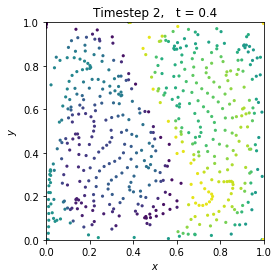

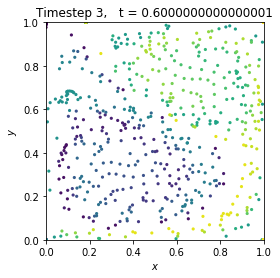

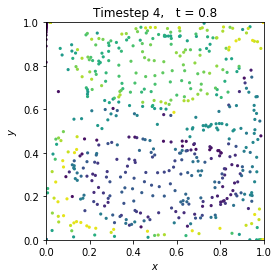

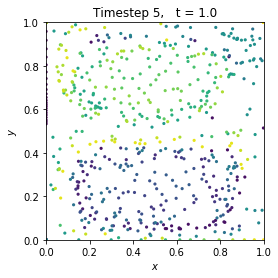

In [10]:
for i in range(nt):
    fig, ax = plt.subplots()
    ax.scatter(p[i,0,:], p[i,1,:], c=X.flatten(), s=10, edgecolors="none")
    ax.set(aspect=1, xlabel='$x$',  ylabel='$y$', xlim = [0,1], ylim=[0,1])
    plt.title('Timestep ' + str(i) +',   t = ' + str(tspan[i]))
    plt.show()

## Step 8: Assemble the Stiffness and Mass Matrices

In [11]:
#delaunay options
options = 'Qt Qbb Qc'

t = [] #stores our Delaunay simplices

D = sp.sparse.csc_matrix((np.square(n), np.square(n)))
M = sp.sparse.csc_matrix((np.square(n), np.square(n)))

for k in range(0,nt):
    t.insert(k, Delaunay(np.transpose(p[k]), qhull_options=options).vertices)
    
    # Want to remove simplices with zero volume
    keep = np.ones(len(t[k]), dtype = bool)
    for i, z in enumerate(t[k]):
        if abs(np.linalg.det(np.hstack((np.transpose(p[k])[z], np.ones([1,3]).T)))) < 1E-15:
            keep[i] = False # Point is coplanar, we don't want to keep it
    t[k] = t[k][keep]

    A = np.kron([1, 0, 1], np.ones((len(t[k]),1)))
    
    [Dt, Mt] = assemble(p[k], t[k], pb, A)
    D = D + Dt
    M = M + Mt

## Step 9: Solve the Eigenproblem, plot eigenvalues and eigenvectors

In [12]:
# Solve Eigenproblem
from scipy.sparse.linalg import eigsh
L,V = eigsh(D.todense(), 10, M.todense(),sigma=0, which='LM')

pos = (-L).argsort()
lam = L[pos]
ord = V[:,pos]

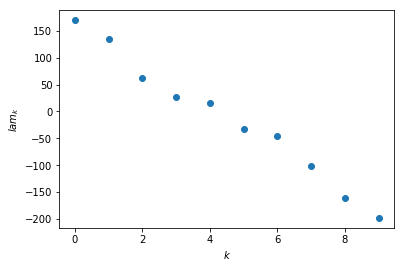

In [13]:
# Plot Eigenvalues
fig, lamx = plt.subplots()
lamx.scatter(np.arange(0,10), lam)
lamx.set(xlabel='$k$',  ylabel='$lam_k$')
plt.show()

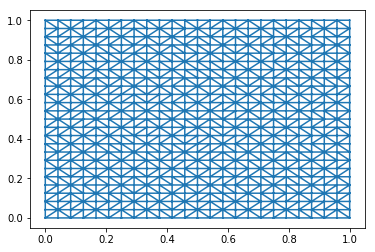

In [14]:
fig, vecx = plt.subplots()
vecx.triplot(p[0][0,:], p[0][1,:],t[0])
plt.show()

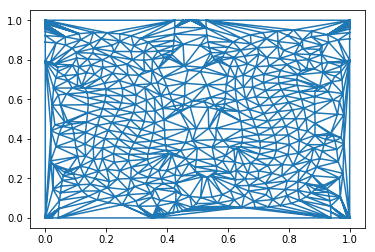

In [15]:
fig, vecx = plt.subplots()
vecx.triplot(p[1][0,:], p[1][1,:],t[1])
plt.show()

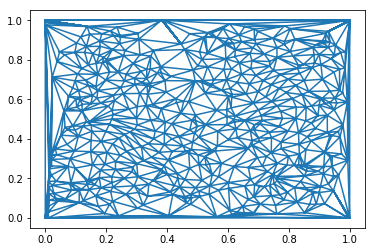

In [16]:
fig, vecx = plt.subplots()
vecx.triplot(p[2][0,:], p[2][1,:],t[2])
plt.show()

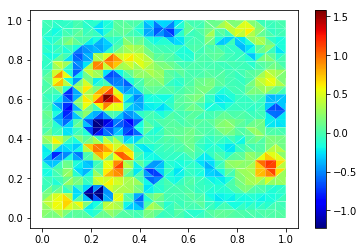

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri
from matplotlib import cm

triang = mtri.Triangulation(p[0,0,:].ravel(), p[0,1,:].ravel(), t[0])

plt.figure()

plt.tripcolor(triang, np.real(ord[:,1]) , cmap=cm.jet, linewidth=0.2, antialiased=True)
plt.colorbar()

plt.show()

## OTHER - TESTING

Text(0.5,1,'Triangulation Visualization')

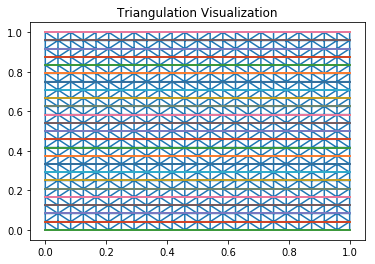

In [18]:
#The Delaunay simplices above are different to the MATLAB output, could this be the problem?

import matplotlib.tri as tri

xPoints = p[0,0,:]
yPoints = p[0,1,:]

gridPoints = np.array([[[x,y] for y in yPoints] for x in xPoints])
triang = tri.Triangulation(gridPoints[:,:,0].flatten(), gridPoints[:,:,1].flatten())
plt.triplot(triang)
plt.plot(gridPoints[:,:,0],gridPoints[:,:,1])
plt.title("Triangulation Visualization")